In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Concatenate, Reshape, Dropout
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np


2023-05-04 21:39:04.688582: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 21:39:05.005338: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 21:39:05.007321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 21:39:06.426542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
sheets_to_use = ["NEG T1", "POS T#1", "NEG T2",
                 "POS T#2", "NEG T3", "POS T#3", "NEG T4", "POS T#4", "NEG T5", "POS T#5", "NEG T6", "POS T#6", "NEG T7", "POS T#7"]

Data = pd.read_excel("./DATASET#1_DELTA_R.xlsx", sheets_to_use)

for k in Data:
    Data[k].drop([0], inplace=True)
    Data[k] = Data[k].iloc[:, :-1]
    Data[k] = Data[k].iloc[:, :9]
    Data[k]["t_value"] = k[-1:]


overall_data = pd.DataFrame(columns=Data[sheets_to_use[0]].columns)

for sheet in sheets_to_use:
    overall_data = pd.concat([overall_data, Data[sheet]])

overall_data.reset_index(inplace=True)
overall_data.drop(columns=["index"], inplace=True)

Data = overall_data
Data = Data.astype(float)
Data["t_value"] = Data["t_value"].astype(np.int32)


In [26]:
Data.describe()


,C1E1,D1,D2,D3,D4,D5,D6,D7,D8,t_value
count,5.600000e+03,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000
mean,-3.045183e-17,9.495709,10.107385,10.008595,10.298424,9.454771,9.685283,11.758435,10.520664,4.000000
std,1.156969e+00,38.103488,47.005986,105.780338,92.588271,48.796601,42.265536,197.875578,55.373723,2.000179
min,-2.000000e+00,-0.984601,-0.984392,-0.985755,-0.991968,-0.993070,-0.997210,-0.997719,-0.996934,1.000000
25%,-1.001250e+00,1.594694,1.505533,1.442995,1.414018,1.330955,1.299645,1.225710,1.218982,2.000000
50%,0.000000e+00,5.232884,5.443610,5.114236,5.100593,4.888961,5.180690,5.048326,5.196186,4.000000
75%,1.001250e+00,12.011073,12.019581,11.503779,11.237823,11.084891,11.131094,10.224442,11.681039,6.000000
max,2.000000e+00,2084.711728,2319.363679,7795.677893,6622.079165,3108.034147,2369.982223,14650.226035,3223.120927,7.000000


In [36]:
# data = pd.get_dummies(Data)
data = Data
data.fillna(data.mean(), inplace=True)

scaler = StandardScaler()
data[data.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(
    data[data.select_dtypes(include=['float64', 'int64']).columns])

# Split data into training and testing sets
train_data, forward_data = train_test_split(data, test_size=0.2)
test_data, val_data = train_test_split(forward_data, test_size=0.5)


In [37]:
# Split features and target variables
train_labels = train_data['t_value']
test_labels = test_data['t_value']
val_labels = test_data['t_value']

train_features = train_data.drop(['t_value',
                             't_value'], axis=1)
test_features = test_data.drop(['t_value',
                           't_value'], axis=1)
val_features = val_data.drop(['t_value',
                          't_value'], axis=1)


In [38]:
[train_features.shape, train_labels.shape], [test_features.shape,
                                         test_labels.shape], [val_features.shape, val_labels.shape]


([(4480, 9), (4480,)], [(560, 9), (560,)], [(560, 9), (560,)])

In [ ]:
# Define the TensorFlow model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=[
                          train_features.shape[1]]),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(16, activation="sigmoid"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(16, activation="sigmoid"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(16, activation="sigmoid"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation="softmax"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001), loss="mse", metrics=["accuracy"])

# Train the model
history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=16,
                    validation_data=(val_features, val_labels)
                    )

# Evaluate the model on the test data
test_loss = model.evaluate(test_features, test_labels)
print("Test loss:", test_loss)


In [47]:
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 32)                320       
                                                                 
 dense_49 (Dense)            (None, 32)                1056      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_50 (Dense)            (None, 32)                1056      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_51 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)               

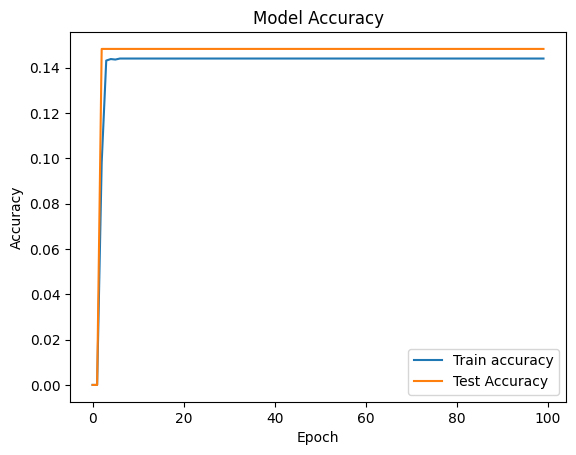

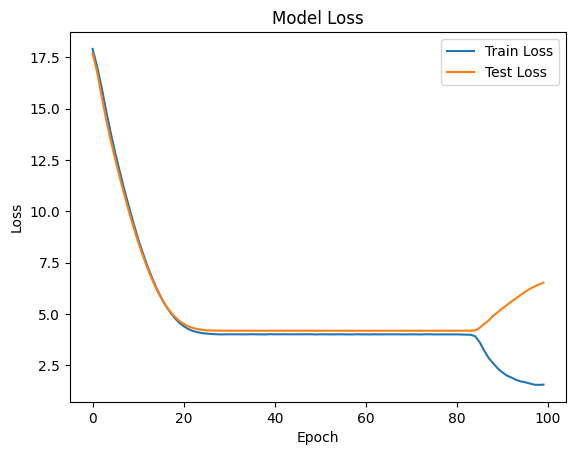

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test Accuracy'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='best')
plt.show()
